In [189]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
#from pandas import read_csv, set_option
from pandas import Series, datetime
from pandas.tools.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
import seaborn as sns
import pickle

In [190]:
# Loading the dataset to a dataframe
sentence_file = "Sentence_Polarity/msw_today.csv"
sentence_df = pd.read_csv(sentence_file)

In [191]:
sentence_df.head()
# sentence_df.iloc[-1]

,Unnamed: 0,Unnamed: 0.1,Date,Title,Subjectivity,Objectivity,Positive,Neutral,Negative
0,0,0.0,2019-11,Pete Buttigieg joins top tier of candidates in...,100.0,0.0,100.0,0.0,0.0
1,1,1.0,2019-11,Chaotic aftermath of Alibaba's Singles' Day se...,NaN,NaN,NaN,NaN,NaN
2,2,2.0,2019-11,Mark Sanford suspends 2020 presidential campaign,NaN,NaN,NaN,NaN,NaN
3,3,3.0,2019-11,The Simpsons aspect ratio is messed up on Disney+,NaN,NaN,NaN,NaN,NaN
4,4,4.0,2019-11,Windows 10 November 2019 Update is now availab...,NaN,NaN,NaN,NaN,NaN


In [192]:
# Check the shape and data types of the dataframe
print(sentence_df.shape)
print(sentence_df.dtypes) 
sentence_df['Subjectivity'] = sentence_df['Subjectivity'].astype(float)
sentence_df['Objectivity'] = sentence_df['Objectivity'].astype(float)
sentence_df['Positive'] = sentence_df['Positive'].astype(float)
sentence_df['Neutral'] = sentence_df['Neutral'].astype(float)
sentence_df['Negative'] = sentence_df['Negative'].astype(float)
print(sentence_df.dtypes) 

(21, 9)
Unnamed: 0        int64
Unnamed: 0.1    float64
Date             object
Title            object
Subjectivity    float64
Objectivity     float64
Positive        float64
Neutral         float64
Negative        float64
dtype: object
Unnamed: 0        int64
Unnamed: 0.1    float64
Date             object
Title            object
Subjectivity    float64
Objectivity     float64
Positive        float64
Neutral         float64
Negative        float64
dtype: object


In [193]:
from datetime import date, timedelta
from datetime import datetime
import timeboard.calendars.US as US
import pytz

# pd.to_datetime(date.today())
# str(date.today())
yesterday = str(date.today() -  timedelta(days = 1))


tz_NY = pytz.timezone('America/New_York') 
datetime_NY = datetime.now(tz_NY)
datetime_NY
currentDayUS = str(pd.to_datetime(datetime_NY)).split(' ')[0]
# print("NY time:", datetime_NY.strftime("%Y:%M:%S"))
yesterdayUS = str(pd.to_datetime(datetime_NY) -  timedelta(days = 1)).split(' ')[0]
# yesterday = pd.to_datetime(yesterdayUS)
currentDayUS
yesterdayUS

clnd = US.Weekly8x5()
lastWorkingDayUS = str(clnd(yesterdayUS).rollback().to_timestamp().date())
lastWorkingDayUS

datetime.datetime(2019, 11, 12, 17, 48, 47, 794000, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>)

'2019-11-12'

'2019-11-11'

'2019-11-08'

In [194]:
from urllib2 import Request
from urllib2 import  urlopen
import json
from pandas.io.json import json_normalize

apiKey = '9AyXbJ2Mzk2M8ptCmzr4YEZTor4KEWBoBtLTscfz4x8Xugh6PnQxLjx38xbt'
index = '^DJI'
yesterdayUS = '2019-11-12'
apiEndPoint = 'https://api.worldtradingdata.com/api/v1/history?symbol=' +index+ '&sort=newest&date_from=' +yesterdayUS+ '&date_to=' + yesterdayUS + '&api_token=' + apiKey

request=Request(apiEndPoint)
response = urlopen(request)
elevations = response.read()
data = json.loads(elevations)
data

{u'history': {u'2019-11-12': {u'close': u'27691.49',
   u'high': u'27770.86',
   u'low': u'27635.32',
   u'open': u'27701.60',
   u'volume': u'213668945'}},
 u'name': u'^DJI'}

In [195]:
import pandas.io.json as pd_json
df = pd_json.json_normalize(data, 
                            record_path='history', 
                            meta=['history'])

numberOfRows = len(df.index)
stonks = pd.DataFrame(index=np.arange(0, numberOfRows), columns=('Date', 'Open', 'High','Low','Close', 'Volume'))
for idx , date in enumerate(data['history']): 
    stonks.loc[idx] = [date 
                       ,data['history'][date]['open']
                       ,data['history'][date]['high']
                       ,data['history'][date]['low']
                       ,data['history'][date]['close']
                       ,data['history'][date]['volume']
                       ]
numberOfRows
stonks.head()

# Check the shape and datatypes of the stock prices dataframe
stock_data = stonks
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Open'] = stock_data['Open'].astype(float)
stock_data['High'] = stock_data['High'].astype(float)
stock_data['Low'] = stock_data['Low'].astype(float)
stock_data['Close'] = stock_data['Close'].astype(float)
stock_data['Volume'] = stock_data['Volume'].astype(float)

print(stock_data.shape)

# Create a dataframe by merging the headlines and the stock prices dataframe
merged_dataframe = sentence_df[[ 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']].merge(stock_data, how='inner',right_index=True, left_index=True)
# Check the shape and top 5 rows of the merged dataframe
print(merged_dataframe.shape)
merged_dataframe.head()

# Push the Label column to the end of the dataframe
cols = list(merged_dataframe)
print(cols)
cols.insert(0,cols.pop(cols.index('Date')))
merged_dataframe = merged_dataframe.ix[:, cols]
merged_dataframe.head()
merged_dataframe.dtypes

1

,Date,Open,High,Low,Close,Volume
0,2019-11-12,27701.60,27770.86,27635.32,27691.49,213668945


(1, 6)
(1, 11)


,Subjectivity,Objectivity,Positive,Negative,Neutral,Date,Open,High,Low,Close,Volume
0,100.0,0.0,100.0,0.0,0.0,2019-11-12,27701.6,27770.86,27635.32,27691.49,213668945.0


['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume
0,2019-11-12,100.0,0.0,100.0,0.0,0.0,27701.6,27770.86,27635.32,27691.49,213668945.0


Date            datetime64[ns]
Subjectivity           float64
Objectivity            float64
Positive               float64
Negative               float64
Neutral                float64
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                 float64
dtype: object

In [196]:
# Print the datatypes and count of the dataframe
# print(merged_dataframe.dtypes)
print(merged_dataframe.count())


X = merged_dataframe.loc[:,'Subjectivity':'Volume']
X_test = X
X_test
# y = merged_dataframe.loc[:,'Label']


Date            1
Subjectivity    1
Objectivity     1
Positive        1
Negative        1
Neutral         1
Open            1
High            1
Low             1
Close           1
Volume          1
dtype: int64


,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume
0,100.0,0.0,100.0,0.0,0.0,27701.6,27770.86,27635.32,27691.49,213668945.0


In [197]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca = pickle.load(open("pca_3.pickle.dat", "rb"))
# pca.fit(X_test)
# X_test.dtypes
transformed = pca.transform(X_test)
transformed

transformed.shape
print(type(transformed))

array([[5.11921455e+07, 3.09100677e+04, 5.44384453e+01]])

(1L, 3L)

<type 'numpy.ndarray'>


In [198]:
pca_df = pd.DataFrame(transformed)

clf = XGBClassifier(n_estimators=500, max_depth=3)
clf = pickle.load(open("xgboost_500_3.pickle.dat", "rb"))

y_pred_pca = clf.predict(pca_df)
y_pred_pca[0]


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0

# ARIMA model:

Lets create an ARIMA model for our time series.

There are a certain checks that needs to be done before applying an ARIMA model on the dataset.

We need to check if there is a trend in our dataset. If there a trend, then we need to apply something called as differenciation to make our data stationary.

By plotting the outputs of the dataset, we see that there is a clear increasing trend.

This means we need to make our data stationary.


In [206]:
from urllib2 import Request
from urllib2 import  urlopen
import json
from pandas.io.json import json_normalize

apiKey = '9AyXbJ2Mzk2M8ptCmzr4YEZTor4KEWBoBtLTscfz4x8Xugh6PnQxLjx38xbt'
index = '^DJI'
apiEndPoint = 'https://api.worldtradingdata.com/api/v1/history?symbol=' +index+ '&sort=oldest&date_from=2009-08-08&api_token=' + apiKey

request=Request(apiEndPoint)
response = urlopen(request)
elevations = response.read()
data = json.loads(elevations)
# data.head()

In [207]:
df = pd_json.json_normalize(data, 
                            record_path='history', 
                            meta=['history'])

numberOfRows = len(df.index)
stonks = pd.DataFrame(index=np.arange(0, numberOfRows), columns=('Date', 'Open', 'High','Low','Close', 'Volume'))
for idx , date in enumerate(data['history']): 
    stonks.loc[idx] = [date 
                       ,data['history'][date]['open']
                       ,data['history'][date]['high']
                       ,data['history'][date]['low']
                       ,data['history'][date]['close']
                       ,data['history'][date]['volume']
                       ]
numberOfRows
stonks.head()

2580

,Date,Open,High,Low,Close,Volume
0,2018-03-06,24965.89,24995.24,24708.41,24884.12,331766021
1,2019-06-06,25567.45,25800.30,25518.05,25720.66,248068144
2,2019-06-07,25768.72,26072.75,25768.72,25983.94,263011043
3,2019-06-04,24962.82,25343.77,24962.82,25332.18,281688224
4,2018-03-07,24758.15,24849.68,24535.12,24801.36,394070603


In [208]:

# Check the shape and datatypes of the stock prices dataframe
stock_data = stonks
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Open'] = stock_data['Open'].astype(float)
stock_data['High'] = stock_data['High'].astype(float)
stock_data['Low'] = stock_data['Low'].astype(float)
stock_data['Close'] = stock_data['Close'].astype(float)
stock_data['Volume'] = stock_data['Volume'].astype(float)

merged_dataframe = stock_data
# Print the datatypes and count of the dataframe
print(merged_dataframe.dtypes)
print(merged_dataframe.count())
# # Change the NaN values to the mean value of that column
# nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
# for col in nan_list:
#     merged_dataframe[col] = merged_dataframe[col].fillna(merged_dataframe[col].mean())

    
merged_dataframe['Date'] = merged_dataframe['Date'].dt.strftime('%Y-%m')
df_dateclose = pd.Series(merged_dataframe['Close'].values, index = merged_dataframe['Date'])

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object
Date      2580
Open      2580
High      2580
Low       2580
Close     2580
Volume    2580
dtype: int64


In [209]:
merged_dataframe = merged_dataframe.sort_values(by = 'Date')
df_dateclose = pd.Series(merged_dataframe['Close'].values, index = merged_dataframe['Date'])

In [210]:
df_dateclose.head()
# df_dateclose = df_dateclose.sort_values(by = 'Date')

Date
2009-08    9505.96
2009-08    9398.19
2009-08    9361.61
2009-08    9241.45
2009-08    9337.95
dtype: float64

In [ ]:

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_dateclose.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=63284259.277
ARIMA(0, 0, 1) MSE=17991220.343
ARIMA(0, 0, 2) MSE=6782507.838
ARIMA(0, 1, 0) MSE=220349.007
ARIMA(0, 1, 1) MSE=173227.418
ARIMA(0, 1, 2) MSE=172834.142
ARIMA(0, 2, 0) MSE=618760.070
ARIMA(0, 2, 1) MSE=220562.115
ARIMA(1, 0, 0) MSE=220872.393
ARIMA(1, 1, 0) MSE=184831.663
ARIMA(1, 1, 1) MSE=172531.362
ARIMA(1, 1, 2) MSE=171508.456
ARIMA(1, 2, 0) MSE=360380.787
ARIMA(2, 0, 0) MSE=185290.867
ARIMA(2, 1, 0) MSE=179159.681
ARIMA(2, 1, 1) MSE=171702.685
ARIMA(2, 1, 2) MSE=172673.859
ARIMA(2, 2, 0) MSE=289746.279
ARIMA(4, 0, 0) MSE=177361.853
ARIMA(4, 1, 0) MSE=174765.470
ARIMA(4, 1, 1) MSE=172253.516
ARIMA(4, 2, 0) MSE=241297.198
ARIMA(6, 1, 0) MSE=174821.365
ARIMA(6, 1, 1) MSE=173047.508
ARIMA(6, 2, 0) MSE=221656.710


array([10040.45, 10174.41, 10014.72, ..., 27347.36, 27691.49, 27691.49])

2329

1537

792

1537

predicted=18270.447117, expected=18066.750000
predicted=18190.270705, expected=18094.830000
predicted=18155.459113, expected=18491.960000
predicted=18301.879547, expected=18085.450000
predicted=18216.494318, expected=18293.700000
predicted=18254.119339, expected=18479.910000
predicted=18354.016144, expected=18034.770000
predicted=18225.743870, expected=18526.140000
predicted=18356.598768, expected=18419.300000
predicted=18388.176807, expected=18538.120000
predicted=18456.280379, expected=18129.960000
predicted=18325.347554, expected=18261.450000
predicted=18303.980565, expected=18392.460000
predicted=18346.244740, expected=18161.190000
predicted=18274.312771, expected=18169.680000
predicted=18235.879478, expected=18199.330000
predicted=18225.859610, expected=18253.850000
predicted=18242.801182, expected=18281.030000
predicted=18264.021941, expected=18168.450000
predicted=18229.365686, expected=18144.200000
predicted=18199.022759, expected=18169.270000
predicted=18191.804696, expected=1

predicted=21233.597461, expected=21235.670000
predicted=21240.993646, expected=21454.610000
predicted=21340.270191, expected=21394.760000
predicted=21370.509021, expected=21349.630000
predicted=21368.002894, expected=21328.470000
predicted=21357.399582, expected=21173.690000
predicted=21284.221197, expected=21136.230000
predicted=21226.455395, expected=21184.040000
predicted=21214.490497, expected=21410.030000
predicted=21305.828367, expected=21310.660000
predicted=21314.429161, expected=21397.290000
predicted=21356.896670, expected=21144.180000
predicted=21271.128041, expected=21182.530000
predicted=21239.146651, expected=21467.140000
predicted=21344.487654, expected=21374.560000
predicted=21364.038823, expected=21528.990000
predicted=21442.110943, expected=21409.550000
predicted=21434.537662, expected=21271.970000
predicted=21370.587255, expected=21287.030000
predicted=21340.853000, expected=21206.290000
predicted=21288.950738, expected=21478.170000
predicted=21377.469068, expected=2

predicted=25325.413617, expected=25219.380000
predicted=25287.887542, expected=25029.200000
predicted=25185.045935, expected=24893.490000
predicted=25068.014652, expected=24601.270000
predicted=24875.150108, expected=24103.110000
predicted=24547.676534, expected=23848.420000
predicted=24246.295622, expected=23857.710000
predicted=24080.273968, expected=24874.760000
predicted=24436.803673, expected=24610.910000
predicted=24520.138219, expected=25335.740000
predicted=24883.943833, expected=24895.210000
predicted=24896.650704, expected=24801.360000
predicted=24862.733966, expected=25178.610000
predicted=25008.468550, expected=24884.120000
predicted=24961.928986, expected=24202.600000
predicted=24638.722007, expected=23533.200000
predicted=24157.617048, expected=24538.060000
predicted=24334.097466, expected=24682.310000
predicted=24493.641509, expected=25007.030000
predicted=24725.183304, expected=24758.120000
predicted=24747.227593, expected=24873.660000
predicted=24810.138360, expected=2

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=26023.224009, expected=25250.550000
predicted=25690.606575, expected=25191.430000
predicted=25475.177789, expected=24583.420000
predicted=25079.677430, expected=24984.550000
predicted=25043.623667, expected=25115.760000
predicted=25083.318424, expected=25379.450000
predicted=25222.881969, expected=25339.990000
predicted=25282.445505, expected=25052.830000
predicted=25187.390554, expected=25598.740000
predicted=25377.995865, expected=25706.680000
predicted=25532.140525, expected=24688.310000
predicted=25164.491291, expected=25444.340000
predicted=25295.964413, expected=25387.180000
predicted=25343.691248, expected=25338.840000
predicted=25348.897514, expected=24748.730000
predicted=25090.573215, expected=24640.240000
predicted=24897.308017, expected=24464.690000
predicted=24710.659093, expected=24465.640000
predicted=24607.550455, expected=24285.950000
predicted=24469.769170, expected=25366.430000
predicted=24877.060128, expected=25380.740000
predicted=25109.349513, expected=2

predicted=27188.335102, expected=27332.030000
predicted=27260.161341, expected=26860.200000
predicted=27089.301305, expected=27088.080000
predicted=27096.337213, expected=27335.630000
predicted=27210.673663, expected=27359.160000
predicted=27284.559937, expected=26864.270000
predicted=27104.814085, expected=27219.850000
predicted=27163.677127, expected=27221.350000
predicted=27196.978709, expected=26922.120000
predicted=27082.111364, expected=27269.970000
predicted=27173.375046, expected=26786.680000
predicted=27008.751204, expected=26717.430000
predicted=26886.332778, expected=26806.140000
predicted=26857.992751, expected=27198.020000
predicted=27016.985920, expected=26783.490000
predicted=26920.509495, expected=26378.190000
predicted=26686.276238, expected=26252.240000
predicted=26499.397067, expected=25962.440000
predicted=26265.270767, expected=25897.710000
predicted=26106.444104, expected=26287.440000
predicted=26195.111910, expected=26135.790000
predicted=26175.588494, expected=2

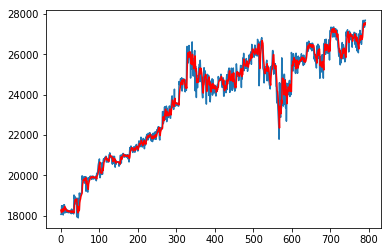

In [205]:
X = df_dateclose.values
X
len(X)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
len(train)
len(test)
# train
history = [x for x in train]
len(history)
predictions = list()
# predictions
final_model = None 
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    if (t == (len(test) -1) ):
        history.append(obs)
        model = ARIMA(history, order=(0,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        print ("Tommorrows Predication:%f " % (yhat))

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

# # future 
# output = final_model.forecast()
# yhat = output[0]
# print ("Tommorrows Predication:%f " % (yhat))